Vérifier la pondération des moyennes

# Complete exploration of first names Biases in NER models


Based on this [article](https://arxiv.org/pdf/2008.03415.pdf), we construct a small datasets with first names associated with ethnicity. 

The goal is to check if the NER model is able to recognize each 'category' with the same results or not. 

Then, we would be able to check the bias in the algorithm.

Question : how are the first names selected ? What is the source ? does it come from [this](https://data.world/johnsnowlabs/most-popular-baby-names-by-gender-and-mother-ethnic-group/workspace/file?filename=Most+Popular+Baby+Names+by+Gender+and+Mother+Ethnic+Group.csv) ?



This notebook is made to explore the possible biases in NER models when applied to the detection of first names. 

Firstly, we will compute the same thing as in the article, then, we will go further by exploring the same hypothesis but with other datasets. 

For each exploration, 4 models will be used: 
- sm
- md
- lg
- trf


We are only testing if the first names are recognized as named entities by the models, but not if they are actually recognized as a person's name. 

This could have been done by using this kind of code : 

`doc.ents[0].label_`

And this would constitute a good improvement of this project, because maybe we could have seen ome other biases - or not - in the label, and could also have defined a different metric. 

But again, here, we are just giving a score of 1 if the name has been recognized and 0 if not. 

Then, we can have a mean results for each of the first names and finally have the results for each group. 


**Steps of this notebook :**
1. **Utils**

The first part of this notebook can be found quite technical. It consists in the developement of several functions used afterwards on all the datasets. 

- Those functions are made to: 
    - Computing the sentences
    - Applying the four models 
    - Getting back the results in a proper way

For all of the expirements of this notebook and in order to construct the sentences, we are using the winogender schemas described in the article. 

Depending on the datasets, some other function are needed, for instance to average the results given the popularity of a first name depending on the birth year on the US baby names dataset. But this last point is developped in the needed parts of this notebook. 

1. **Article**

The first real exploration of the biases consists in following the exact same steps followed by the article mentionned above. 
We are using the same schemas and the same first names. 

2. **US baby names dataset - nation wise**



3. **NYC baby names**

Given that in the article researchers did not say exactly how they selected the first names, we wanted to go a little bit further. 

4. **US baby names dataset - states**

## Necessary imports:

In [2]:
import geopandas as gpd

import pandas as pd
import numpy as np

from tqdm import tqdm
import random


#Viz:
import seaborn as sns
import matplotlib.pyplot as plt

%matplotlib inline

#Spacy:
import spacy
from spacy import displacy

## Utils

### Winogender

We also have to build templates for the sentences. 

Just as in the article, we're using the winogender schemas, which was made to check gender biases in algorithmic procedures. The project consists in basic sentences, with some variables like : `$Participant`, `$Occupation` or `$Pronoun`, which can then be replaced by actual names. 

The github page of the project can be found [here](https://github.com/rudinger/winogender-schemas), and the page of the templates we're using can be found [here](https://github.com/rudinger/winogender-schemas/blob/master/data/templates.tsv). 

In [3]:
#Accessing the templates : 
templates_sentences = pd.read_csv('https://raw.githubusercontent.com/rudinger/winogender-schemas/master/data/templates.tsv', sep='\t')

We have to make some modifications because the templates were not actually intended to be used with actual first names. 

For instance, There is often `The` before the word `$Occupation` - because it was intended to used with an occupation. 

Then, we have to delete this 'the' when it is present. 

We also have to check if there are indeed 3 possible names in each sentence, and if the pronoun is a nominative one -to avoid any english mistake. 

In [4]:
#We need to delete the 'THE' before occupation and participant :
def make_template_right(sent):    
    l_sent = sent.split()
    i_occupation = l_sent.index('$OCCUPATION')
    if i_occupation != 0: 
        if l_sent[i_occupation-1].lower() == 'the': 
            del l_sent[i_occupation-1]

    #Same thing with $PARTICIPANT : 

    i_participant = l_sent.index('$PARTICIPANT')
    if i_participant != 0: 
        if l_sent[i_participant-1].lower() == 'the': 
            del l_sent[i_participant-1]

    #Building up the sentence again: 
    return ' '.join(l_sent)

In [5]:
#Applying the function to the dataframe: 
tqdm.pandas()
templates_sentences['right_sentence'] = templates_sentences['sentence'].progress_apply(make_template_right)

100%|████████████████████████████████████████████████████████████████████████████| 120/120 [00:00<00:00, 119666.31it/s]


In [6]:
#We only take into account the nomitative pronouns to form exact sentences:
def check_three_items(sentence):
    if '$OCCUPATION' in sentence:
        if '$PARTICIPANT' in sentence:
            if '$NOM_PRONOUN' in sentence:
                return 1
    return 0 

In [7]:
#Applying the function described above and selecting only the sentences with three items:
templates_sentences['three_items'] = templates_sentences['right_sentence'].apply(check_three_items)
templates_sentences = templates_sentences[templates_sentences['three_items']==1]

### Function to compute sentences

In [8]:
#In each template sentence, there are : 
# $OCCUPATION // $PARTICIPANT  // $NOM_PRONOUN
#Then, we just have to replace each thing with a first name.

def compute_random_sentences(row, arr_names, template=templates_sentences):
    """
    The template has to have a column 'right_sentence'
    """    
    #Firstly we need to take one sentence at random:
    str_sentence = template.sample(1)['right_sentence'].values[0]
    #The names should not be all the same: 
    random_occupation = random.choice(arr_names)
    random_participant=random_occupation
    while random_occupation == random_participant:
        random_participant = random.choice(arr_names)
    random_pronoun = random_occupation
    while random_pronoun == random_occupation or random_pronoun == random_participant:
        random_pronoun = random.choice(arr_names)
           
    
    #we replace the right words to form the finale sentence: 
    str_sentence=str_sentence.replace('$OCCUPATION', random_occupation)
    str_sentence=str_sentence.replace('$PARTICIPANT', random_participant)
    str_sentence=str_sentence.replace('$NOM_PRONOUN', random_pronoun)
    return str_sentence, random_occupation, random_participant, random_pronoun

### Models

We are using spacy to test the NER algorithms.

We are testing the 4 models implemented in version 3.1 of Spacy: 

- sm
- md
- lg
- trf

We load the four models at once:

In [10]:
nlp_sm = spacy.load("en_core_web_sm")
nlp_md = spacy.load("en_core_web_md")
nlp_lg = spacy.load("en_core_web_lg")
nlp_trf = spacy.load("en_core_web_trf")

In [11]:
def predict_NER_spacy(text, model):
    """
    This function just consists in applying a given NER model to a given text. 
    
    @Inputs:
        text: str, the text the model is applied on
        
        model: str, the model to be used, either:
                - 'sm'
                - 'md'
                - 'lg'
                - 'trf'
    @Outputs:
        - predicted_label_liste, list, the list of the named entities recognized by the specified model. 
    """
    if model=='sm':
        doc=nlp_sm(text)
    elif model=='md':
        doc=nlp_md(text)
    elif model=='lg':
        doc=nlp_lg(text)
    elif model=='trf':
        doc=nlp_trf(text)
    else:
        return np.nan
        
    predicted_label_liste=[str(ent).strip() for ent in doc.ents]
    return predicted_label_liste

### Was the name found?

In [12]:
#Is the name found ?? 
def check_names_prediction(row):
    """
    Function check_names_prediction
    
    @Inputs:
        - row of a dataframe cointaing at least 4 columns: 
            - '0', '1' and '2': specifying the three persons names.
            - 'spacy_prediction': the prediction of the model. 
                See the function main_ner_first_names for more detailed information. 
    @Outputs:
        - var_0, var_1, var_2, int, either 0 or 1, specifying if the name n has been recognized(1) or not(0).
    """
    var_0, var_1, var_2 = 0,0,0
    if row['0'] in row['spacy_prediction']:
        var_0 = 1
    if row['1'] in row['spacy_prediction']:
        var_1 = 1
    if row['2'] in row['spacy_prediction']:
        var_2 = 1    
    return var_0, var_1, var_2

### Computing the stats:

In [13]:
def compute_stats_names(df_test_names, model):
    """
    Model is a str of the name of the model
    
    """
    #Creating a new dataframe:
    df_temp=pd.DataFrame()
    df_temp['score_'+model] = pd.concat([df_test_names['0_found'], df_test_names['1_found'], df_test_names['2_found']])
    df_temp['name'] = pd.concat([df_test_names['0'], df_test_names['1'], df_test_names['2']])
    #We then have one 'mean' score per name:
    df_temp = df_temp.groupby('name').agg({'score_'+model:'mean'}).reset_index(drop=False)
    return df_temp

### main():

In [14]:
def main_ner_first_names(n_sentences, arr_names, template=templates_sentences):
    """
    In this function, we are computing the sentences, applying the model. 
    
    Then, each name has a 'mean' score. 
    """
    #We are computing the sentences, given the arr_names and the number of sentences:
    df_test_names = pd.DataFrame(index=range(n_sentences))
    df_test_names['tt']= 1 
    df_test_names['sentence'], df_test_names['0'], df_test_names['1'], df_test_names['2'] = zip(*df_test_names.apply(lambda x: compute_random_sentences(x, arr_names, template), axis=1))
    del df_test_names['tt']
    
    
    
    #We define the df of the results:
    df_results=pd.DataFrame(data={'name':arr_names})
    
    #Then, we apply the models:
    for model in ['sm', 'md', 'lg', 'trf']:
        
        print('Testing the model: '+model)
        
        
        tqdm.pandas()
        df_test_names['spacy_prediction'] = df_test_names['sentence'].progress_apply(lambda x: predict_NER_spacy(x, model))
        #We replace the list with a string, because otherwise for a list like : [Emily if Camila], neither Emily or Camila 
        #Would be mark as 1 by the test above. 
        df_test_names['spacy_prediction'] = df_test_names['spacy_prediction'].apply(lambda l : ' '.join(l))
        #We apply the function to check if the names were understood as NER by the model: 
        df_test_names['0_found'], df_test_names['1_found'], df_test_names['2_found'] = zip(*df_test_names.apply(check_names_prediction, axis=1))
        #computing the stats:
        #And merging with the results df:
        df_results = df_results.merge(compute_stats_names(df_test_names, model), left_on='name', right_on='name', how='right')
        

    return df_results

## Names based on the article

We are here using the names described in [that article](https://arxiv.org/pdf/2008.03415.pdf).

We are using the exact same names as in the article. 

Each category is composed of 15 names. 

### Constructing the dataset

In [15]:
#Black Female = BF_names
BF_names = ['Aaliyah', 'Ebony', 'Jasmine', 'Lakisha', 'Latisha',
'Latoya', 'Malika', 'Nichelle', 'Nishelle', 'Shanice',
'Shaniqua', 'Shereen', 'Tanisha', 'Tia', 'Yolanda','Yvette']
#Black Male = BM_names
BM_names = ['Alonzo', 'Alphonse', 'Darnell', 'Deion', 'Jamel',
'Jerome', 'Lamar', 'Lamont', 'Leroy', 'Lionel', 'Malik',
'Terrence', 'Theo', 'Torrance', 'Tyree']
#Hispanic Female = HF_names
HF_names=['Ana', 'Camila', 'Elena', 'Isabella', 'Juana', 'Luciana', 'Luisa', 'Maria', 'Mariana', 'Martina', 'Sofia',
'Valentina', 'Valeria', 'Victoria', 'Ximena']
#Hispanic Male = HM_names
HM_names = ['Alejandro', 'Daniel', 'Diego', 'Jorge', 'Jose', 'Juan',
'Luis', 'Mateo', 'Matias', 'Miguel', 'Nicolas', 'Samuel',
'Santiago', 'Sebastian', 'Tomas']
#Muslim Female = MF_names
MF_names = ['Alya', 'Ayesha', 'Fatima', 'Jana', 'Lian', 'Malak',
'Mariam', 'Maryam', 'Nour', 'Salma', 'Sana', 'Shaista',
'Zahra', 'Zara', 'Zoya']
#Muslim Male = MM_names
MM_names = ['Abdullah', 'Ahmad', 'Ahmed', 'Ali', 'Ayaan', 'Hamza',
'Mohammed', 'Omar', 'Rayyan', 'Rishaan', 'Samar',
'Syed', 'Yasin', 'Youssef', 'Zikri']
#White Female = WF_names
WF_names = ['Amanda', 'Betsy', 'Colleen', 'Courtney', 'Ellen',
'Emily', 'Heather', 'Katie', 'Kristin', 'Lauren', 'Megan',
'Melanie', 'Nancy', 'Rachel', 'Stephanie']
#White Male = WM_names
WM_names = ['Adam', 'Alan', 'Andrew', 'Brad', 'Frank', 'Greg',
'Harry', 'Jack', 'Josh', 'Justin', 'Matthew', 'Paul', 'Roger',
'Ryan', 'Stephen']


#Defining the list of origins:
list_origins = ['BF_names', 'BM_names', 'HF_names', 'HM_names', 'MF_names', 'MM_names',
               'WF_names', 'WM_names']

#Defining the Datafram 'df_complete_names' with two columns - 'name' and 'origin' - containing every first names
df_complete_names = pd.DataFrame(columns=['name', 'origin'])
for origin in list_origins: 
    df_temp = pd.DataFrame()
    df_temp['name'] = globals()[origin]
    df_temp['origin'] = origin
    df_complete_names = pd.concat([df_complete_names, df_temp])
df_complete_names.reset_index(drop=True, inplace=True)

In [16]:
df_complete_names.head()

,name,origin
0,Aaliyah,BF_names
1,Ebony,BF_names
2,Jasmine,BF_names
3,Lakisha,BF_names
4,Latisha,BF_names


In [17]:
#Constructing the array of the unique names:
arr_names_article=df_complete_names['name'].unique()

### Results

We are then applying the function `main_ner_first_names` on those names, with a number of computed sentences.

**Why are we not using every possible sentences - with every possible permutations ?**

```
Since there are 89 unique template sentences, and 121 unique names in total, we would have 1 727 880 3-ordered permutation of every names. 

Thus 89 * 1 727 880 =  153 781 320 sentences we should apply the models on. 
```

Even if doing so would have been a bit better because it would have given us reproductible results, we do not have access to enough computational ressources.

Then, what we are doing is picking randomly 3 different first names from the dataframe, and picking one sentence. 

But in order to conterbalance this randomness, we are doing this on a large amont of sentences. 

In [18]:
df_results_article = main_ner_first_names(100000, arr_names_article)

Testing the model: sm


100%|█████████████████████████████████████████████████████████████████████████| 100000/100000 [09:40<00:00, 172.28it/s]


Testing the model: md


100%|█████████████████████████████████████████████████████████████████████████| 100000/100000 [12:37<00:00, 132.08it/s]


Testing the model: lg


100%|█████████████████████████████████████████████████████████████████████████| 100000/100000 [13:02<00:00, 127.87it/s]


Testing the model: trf


100%|████████████████████████████████████████████████████████████████████████| 100000/100000 [1:38:56<00:00, 16.85it/s]


In [20]:
 #Saving and visualising the results:
df_results_article.to_csv('data/results/df_results_article_100000.csv', index=False)
df_results_article.head()

,name,score_sm,score_md,score_lg,score_trf
0,Aaliyah,0.898539,1.000000,1.000000,0.979958
1,Abdullah,0.997626,1.000000,1.000000,0.995251
2,Adam,0.072328,0.031694,0.013003,0.861845
3,Ahmad,0.999194,1.000000,1.000000,0.993145
4,Ahmed,0.968472,1.000000,0.997575,0.997979


### Viz

In [21]:
list_female = ['WF_names', 'BF_names', 'HF_names', 'MF_names']
list_male = ['WM_names', 'HM_names', 'BM_names', 'MM_names']

#Get ethnicity and gender for each name:
def compute_gender(origin):
    if origin in list_female:
        return 'male'
    else:
        return 'female'
    
def compute_ethnicity(origin):
    if origin in ['WF_names', 'WM_names']:
        return 'white'
    elif origin in ['BF_names', 'BM_names']:
        return 'black'
    elif origin in ['MF_names', 'MM_names']:
        return 'muslim'
    else:
        return 'hispanic'

df_results_article = df_results_article.merge(df_complete_names, left_on='name', right_on='name', how='left')
df_results_article['ethnicity'] = df_results_article['origin'].apply(compute_ethnicity)
df_results_article['gender'] = df_results_article['origin'].apply(compute_gender)

In [22]:
df_results_article_gb = df_results_article.groupby(['ethnicity', 'gender']).agg({'score_sm':'mean', 'score_md':'mean', 'score_lg':'mean', 'score_trf':'mean'})
#Compute the average score for all the models:
df_results_article_gb['avg_score']=df_results_article_gb[['score_sm', 'score_md', 'score_lg', 'score_trf']].mean(axis=1)

#### General results

In [23]:
df_results_article_gb

score_sm  score_md  score_lg  score_trf  avg_score
ethnicity gender                                                    
black     female  0.506960  0.955462  0.983615   0.935952   0.845497
          male    0.754428  0.809577  0.896094   0.949815   0.852479
hispanic  female  0.630775  0.912681  0.934434   0.957053   0.858736
          male    0.767468  0.992429  0.974149   0.960799   0.923711
muslim    female  0.839875  0.889728  0.853689   0.986949   0.892560
          male    0.714370  0.958957  0.815143   0.969916   0.864596
white     female  0.802496  0.813812  0.809168   0.890909   0.829097
          male    0.774724  0.958451  0.994145   0.985070   0.928098

#### Results based on the ethnicity

In [24]:
df_results_article_gb.groupby('ethnicity').mean()

,score_sm,score_md,score_lg,score_trf,avg_score
ethnicity,,,,,
black,0.630694,0.882520,0.939854,0.942884,0.848988
hispanic,0.699121,0.952555,0.954291,0.958926,0.891223
muslim,0.777122,0.924343,0.834416,0.978432,0.878578
white,0.788610,0.886132,0.901656,0.937990,0.878597


#### Results based on the gender

In [25]:
df_results_article_gb.groupby('gender').mean()

,score_sm,score_md,score_lg,score_trf,avg_score
gender,,,,,
female,0.695026,0.892921,0.895226,0.942716,0.856472
male,0.752748,0.929853,0.919882,0.966400,0.892221


## US Baby names

### Importing the dataset

In [26]:
df_us_names = pd.read_csv('Data/us_baby_names/NationalNames.csv')

In [27]:
del df_us_names['Id']
df_us_names.head()

,Name,Year,Gender,Count
0,Mary,1880,F,7065
1,Anna,1880,F,2604
2,Emma,1880,F,2003
3,Elizabeth,1880,F,1939
4,Minnie,1880,F,1746


In [28]:
df_us_names['Name'].nunique()

93889

There are a lot of names in the dataframe, thus we're only taking the n most popular names for each year and each gender:

In [29]:
#df_us_names[df_us_names['Count']>1000].sample(100, random_state=42).sort_values('Year').head()
arr_us_names = df_us_names.groupby(['Year','Gender'])[['Count', 'Name']].apply(lambda x: x.nlargest(10, columns=['Count']))['Name'].unique()
print('total number of names considered:', arr_us_names.shape[0])
#Also computing the total list of years:
liste_years = df_us_names.sort_values('Year')['Year'].unique()

total number of names considered: 129


### Results

In [30]:
df_results_us = main_ner_first_names(100000, arr_us_names)

Testing the model: sm


100%|█████████████████████████████████████████████████████████████████████████| 100000/100000 [08:09<00:00, 204.21it/s]


Testing the model: md


100%|█████████████████████████████████████████████████████████████████████████| 100000/100000 [09:03<00:00, 184.03it/s]


Testing the model: lg


100%|█████████████████████████████████████████████████████████████████████████| 100000/100000 [09:01<00:00, 184.78it/s]


Testing the model: trf


100%|████████████████████████████████████████████████████████████████████████| 100000/100000 [1:31:42<00:00, 18.17it/s]


In [32]:
#Saving the results:
df_results_us.to_csv('data/results/df_results_us_nation_100000.csv', index=False)
df_results_us.head()

,name,score_sm,score_md,score_lg,score_trf
0,Abigail,0.999143,1.000000,1.000000,0.763068
1,Aiden,0.487489,0.678602,0.984469,0.901639
2,Alexander,0.635550,0.995311,1.000000,0.867860
3,Alexis,0.701769,0.975990,0.994524,0.915754
4,Alice,0.671692,1.000000,1.000000,0.954355


In [33]:
#Getting the array of the names really used inside the algorithm:
new_us_names=df_results_us['name'].unique()

In [34]:
def compute_score_year(year, model):
    n_people = 0
    dict_sum_scores = {'sm': 0, 'md':0, 'lg':0, 'trf':0}
    for name in new_us_names:
        try:
            df_temp_year = df_us_names[df_us_names['Year']==year]
            n=df_temp_year[df_temp_year['Name']==name]['Count'].values[0]
            n_people+=n
            for model in ['sm', 'md', 'lg', 'trf']:
                dict_sum_scores[model] += df_results_us[df_results_us['name']==name]['score_'+model].values[0]*n
        except:
            n_people+=0
    return {k:v/n_people for k,v in dict_sum_scores.items()}

In [37]:
#Averaging the score on the years:
    #Defining the dataframe:
df_us_final_results = pd.DataFrame(data = {'year':liste_years})
    #Getting the scores:
tqdm.pandas()

for model in ['sm', 'md', 'lg', 'trf']:
    df_us_final_results['d']= df_us_final_results['year'].progress_apply(lambda x: compute_score_year(x, model))
    df_us_final_results['score_'+model] = df_us_final_results['d'].apply(pd.Series)[model]
del df_us_final_results['d']

100%|████████████████████████████████████████████████████████████████████████████████| 135/135 [01:20<00:00,  1.69it/s]


In [38]:
df_us_final_results.head()

,year,score_sm,score_md,score_lg,score_trf
0,1880,0.792332,0.913002,0.969546,0.865559
1,1881,0.807298,0.924330,0.980426,0.872076
2,1882,0.785082,0.914942,0.971416,0.867883
3,1883,0.799331,0.924311,0.976894,0.870924
4,1884,0.787200,0.920353,0.975658,0.869222


In [39]:
#We are computing the average score of the models:
df_us_final_results['avg_score']=df_us_final_results[['score_sm', 'score_md', 'score_lg', 'score_trf']].mean(axis=1)

### Viz

Plotting the results of all the models. 

C:\Users\adrie\AppData\Roaming\Python\Python37\site-packages\matplotlib\cbook\__init__.py:2064: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  x[:, None]
C:\Users\adrie\AppData\Roaming\Python\Python37\site-packages\matplotlib\axes\_base.py:248: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  x = x[:, np.newaxis]
C:\Users\adrie\AppData\Roaming\Python\Python37\site-packages\matplotlib\axes\_base.py:250: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  y = y[:, np.newaxis]


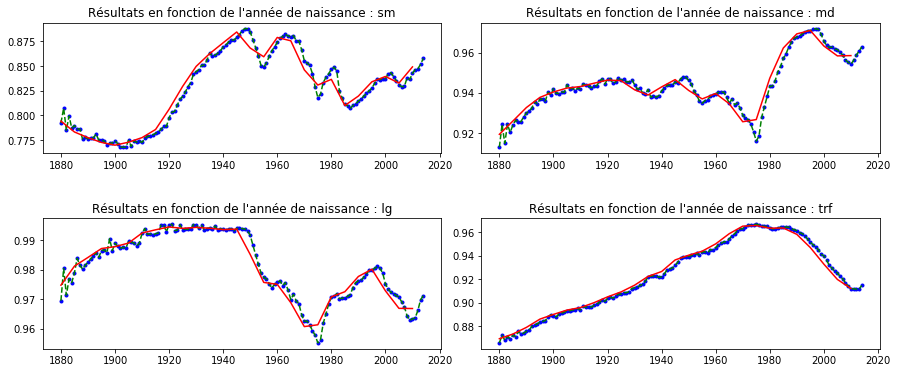

In [40]:
fig, axs = plt.subplots(2,2, figsize=(15, 6), facecolor='w', edgecolor='k')
fig.subplots_adjust(hspace = .5, wspace=0.1)

axs = axs.ravel()

for i in range(4):
    model = ['sm','md','lg','trf'][i]
    #Computing the mean scores by range of every 5 years:
    arr=df_us_final_results['score_'+model].values
    y_mean_5=np.mean(arr.reshape(-1, 5), axis=1)
    x_mean_5=np.array([x for x in range(1880, 2015, 5)])


    x=df_us_final_results['year']
    y= df_us_final_results['score_'+model]


    #Defining the figure:
    axs[i].set_title('Résultats en fonction de l\'année de naissance : ' + model)
    axs[i].plot(x, y, 'o', color='b', markersize=3, label='raw')
    axs[i].plot(x, y, '--', color='g', markersize=3, label='line')
    axs[i].plot(x_mean_5, y_mean_5, color = 'r', label='mean for every 5y')

Average score of the 4 models:

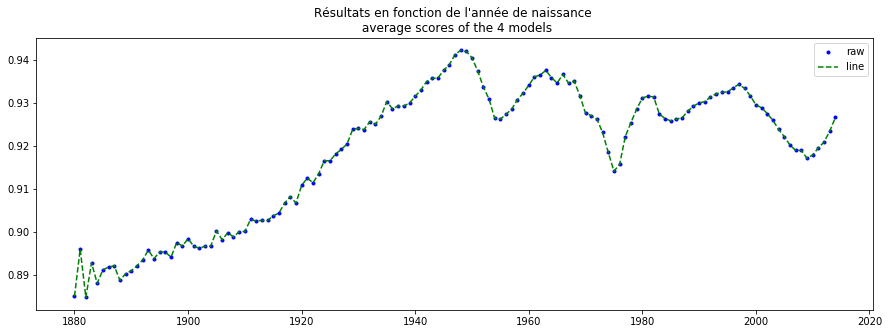

In [41]:
x=df_us_final_results['year']
y=df_us_final_results['avg_score']

fig= plt.figure(figsize=(15,5))
plt.title('Résultats en fonction de l\'année de naissance \n average scores of the 4 models')
plt.plot(x, y, 'o', color='b', markersize=3, label='raw')
plt.plot(x, y, '--', color='g', markersize=3, label='line')
plt.legend()
plt.show()

In [42]:
df_us_final_results.sort_values('avg_score', ascending=False)[['year', 'avg_score']].head(5)

,year,avg_score
68,1948,0.942201
69,1949,0.941947
67,1947,0.941186
70,1950,0.940492
66,1946,0.938860


Boomers birthyears!!!!!

On peut faire la même chose avec l'âge:

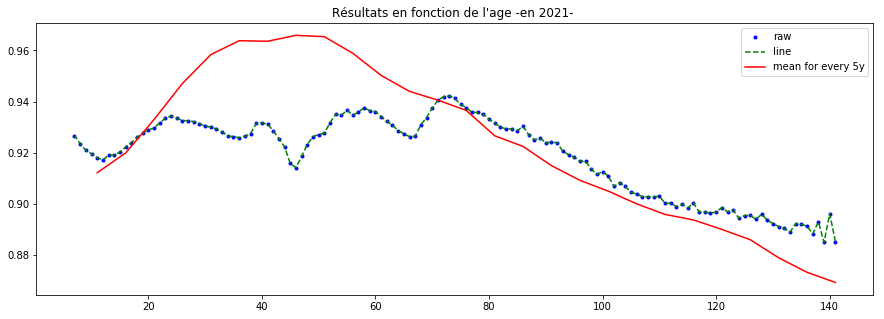

In [44]:
fig= plt.figure(figsize=(15,5))
plt.title('Résultats en fonction de l\'age -en 2021- ')
plt.plot(2021-x, y, 'o', color='b', markersize=3, label='raw')
plt.plot(2021-x, y, '--', color='g', markersize=3, label='line')
plt.plot(2021-x_mean_5, y_mean_5, color = 'r', label='mean for every 5y')
plt.legend()
plt.show()

## NYC

We're using the NYC dataset with ethnicity in it to go further than the article. 

### Importing and cleaning the dataframe

In [ ]:
df_nyc_names = pd.read_csv('Data/NYC_Popular_Baby_Names.csv')

In [ ]:
df_nyc_names.head()

In [ ]:
#Some names are not written in the same way, so we title them all:
df_nyc_names["Child's First Name"]= df_nyc_names["Child's First Name"].str.title()

#There are also some mistakes in the way the ethnicity is written: 
d_replace_ethnicity = {"ASIAN AND PACI" : 'ASIAN AND PACIFIC ISLANDER', 
            "BLACK NON HISP" : "BLACK NON HISPANIC", 
            "WHITE NON HISP" : "WHITE NON HISPANIC"}


df_nyc_names["Ethnicity"]=df_nyc_names["Ethnicity"].replace(d_replace_ethnicity)

#We sum up the count for each first name -depending on the gender and ethnicity-:
df_nyc_names=df_nyc_names.groupby(["Child's First Name", "Ethnicity", "Gender"]).agg({'Count':'sum'}).reset_index(drop=False)

In [ ]:
#There are too much names, Thus:
#We are taking the 10 most common names for each ethnicity and each gender:
arr_nyc_names = df_nyc_names.groupby(['Ethnicity','Gender'])[['Count', "Child's First Name"]]\
.apply(lambda x: x.nlargest(10, columns=['Count']))["Child's First Name"].unique()

### Results

In [ ]:
df_results_nyc = main_ner_first_names(10000, arr_nyc_names)

Then, we have a score for each first name. 

In [ ]:
#Getting the array of the names actually used by the model:
new_names_nyc = df_results_nyc['name'].unique()

#### Ethnicity:

In [ ]:
#Getting the complete list of ethnicities inside the dataframe:
liste_ethnicity = df_nyc_names['Ethnicity'].unique()

In [ ]:
def compute_score_ethnicity(ethnicity):
    n_people = 0
    dict_sum_scores = {'sm': 0, 'md':0, 'lg':0, 'trf':0}
    for name in new_names_nyc:
        try:
            df_temp_year = df_nyc_names[df_nyc_names['Ethnicity']==ethnicity]
            n=df_temp_year[df_temp_year["Child's First Name"]==name]['Count'].values[0]
            n_people+=n
            for model in ['sm', 'md', 'lg', 'trf']:
                dict_sum_scores[model] += df_results_nyc[df_results_nyc['name']==name]['score_'+model].values[0]*n
        except:
            n_people+=0
    
    return {k:v/np.maximum(n_people,1) for k,v in dict_sum_scores.items()}

In [ ]:
#Averaging the score on the years:
    #Defining the dataframe:
df_nyc_final_results = pd.DataFrame(data = {'ethnicity':liste_ethnicity})
    #Getting the scores:
tqdm.pandas()
df_nyc_final_results['d']= df_nyc_final_results['ethnicity'].progress_apply(lambda x: compute_score_ethnicity(x))
    
for model in ['sm', 'md', 'lg', 'trf']:
    df_nyc_final_results['score_'+model] = df_nyc_final_results['d'].apply(pd.Series)[model]
del df_nyc_final_results['d']

In [ ]:
df_nyc_final_results

Computing the average score:

In [ ]:
#We are computing the average score of the models:
df_nyc_final_results['avg_score']=df_nyc_final_results[['score_sm', 'score_md', 'score_lg', 'score_trf']].mean(axis=1)

In [ ]:
df_nyc_final_results

#### Gender

In [ ]:
df_results_gender = df_results_nyc.copy()
df_nyc_gender = df_nyc_names.groupby(["Child's First Name", 'Gender']).agg({'Count':'sum'}).reset_index(drop=False)
df_nyc_gender=df_nyc_gender.groupby("Child's First Name")[["Count", 'Gender']].apply(lambda x: x.nlargest(1, columns=['Count'])).reset_index(drop=False)
df_results_gender['gender']=df_results_gender['name'].apply(lambda x: df_nyc_gender[df_nyc_gender["Child's First Name"]==x]['Gender'].values[0])

In [ ]:
df_results_gender=df_results_gender.groupby('gender').agg({'score_sm':'mean', 'score_md':'mean', 'score_lg':'mean', 'score_trf':'mean'})

In [ ]:
#We are computing the average score of the models:
df_results_gender['avg_score']=df_results_gender[['score_sm', 'score_md', 'score_lg', 'score_trf']].mean(axis=1)

In [ ]:
df_results_gender

## US states

### Importing the dataset and cleaning it 

In [2]:
df_states_names=pd.read_csv('data/us_baby_names/StateNames.csv')

In [3]:
df_states_names.head()

,Id,Name,Year,Gender,State,Count
0,1,Mary,1910,F,AK,14
1,2,Annie,1910,F,AK,12
2,3,Anna,1910,F,AK,10
3,4,Margaret,1910,F,AK,8
4,5,Helen,1910,F,AK,7


We groupby to avoid taking the year in consideration:

In [4]:
df_states_names=df_states_names.groupby(['Name', 'Gender', 'State']).agg({'Count':'sum'}).reset_index(drop=False)

In [5]:
df_states_names.head()

,Name,Gender,State,Count
0,Aaban,M,NY,12
1,Aadan,M,CA,18
2,Aadan,M,TX,5
3,Aadarsh,M,IL,5
4,Aaden,M,AL,78


Then we are doing the exact same things as before:

**But we take n=20**

In [6]:
arr_states_names = df_states_names.groupby(['State','Gender'])[['Count', 'Name']].apply(lambda x: x.nlargest(20, columns=['Count']))['Name'].unique()
print('total number of names considered:', arr_states_names.shape[0])
#Also computing the total list of states
liste_states = df_states_names['State'].unique()

total number of names considered: 117


### Results

In [9]:
df_results_states = main_ner_first_names(10000, arr_states_names)

NameError: name 'main_ner_first_names' is not defined

In [10]:
#df_results_states.to_csv('Data/results/df_results_states.csv', index=False)
df_results_states = pd.read_csv('data/results/df_results_states.csv')

In [11]:
df_results_states.head()

,name,score_sm,score_md,score_lg,score_trf
0,Alexis,0.666667,0.969349,0.992337,0.892720
1,Amanda,0.889734,1.000000,1.000000,0.996198
2,Amber,0.065455,0.734545,0.996364,0.985455
3,Amy,0.142361,0.118056,0.496528,0.982639
4,Andrea,1.000000,1.000000,1.000000,0.969112


In [12]:
#Getting the array of the names really used inside the algorithm:
new_states_names=df_results_states['name'].unique()

In [13]:
def compute_score_state(state):
    n_people = 0
    dict_sum_scores = {'sm': 0, 'md':0, 'lg':0, 'trf':0}
    for name in new_states_names:
        try:
            df_temp_state = df_states_names[df_states_names['State']==state]
            n=df_temp_state[df_temp_state['Name']==name]['Count'].values[0]
            n_people+=n
            for model in ['sm', 'md', 'lg', 'trf']:
                dict_sum_scores[model] += df_results_states[df_results_states['name']==name]['score_'+model].values[0]*n
        except:
            n_people+=0
    return {k:v/n_people for k,v in dict_sum_scores.items()}

In [14]:
#Averaging the score on the years:
    #Defining the dataframe:
df_states_final_results = pd.DataFrame(data = {'state':liste_states})
    #Getting the scores:
tqdm.pandas()
df_states_final_results['d']= df_states_final_results['state'].progress_apply(compute_score_state)
    
for model in ['sm', 'md', 'lg', 'trf']:
    df_states_final_results['score_'+model] = df_states_final_results['d'].apply(pd.Series)[model]
del df_states_final_results['d']

100%|██████████████████████████████████████████████████████████████████████████████████| 51/51 [01:47<00:00,  2.11s/it]


In [15]:
#We are computing the average score of the models:
df_states_final_results['avg_score']=df_states_final_results[['score_sm', 'score_md', 'score_lg', 'score_trf']].mean(axis=1)

In [16]:
df_states_final_results.head()

,state,score_sm,score_md,score_lg,score_trf,avg_score
0,NY,0.869524,0.950158,0.984111,0.933121,0.934228
1,CA,0.863705,0.952241,0.978210,0.945180,0.934834
2,TX,0.844008,0.943142,0.973913,0.931953,0.923254
3,IL,0.852882,0.937098,0.972281,0.931988,0.923562
4,AL,0.816079,0.911139,0.946560,0.906097,0.894969


### Viz

To visualise the results, we need to find the geographical limits of each state. 

We found it in the state 21_basic dataset (Source) 

[Source](https://alicia.data.socrata.com/Government/States-21basic/jhnu-yfrj) of the state 21_basic dataset

In [17]:
gdf_states = gpd.read_file('Data/States 21basic.geojson')

In [18]:
del gdf_states['state_fips']
del gdf_states['drawseq']
del gdf_states['sub_region']

In [19]:
gdf_states.head()

,state_abbr,state_name,geometry
0,HI,Hawaii,"MULTIPOLYGON (((-160.07380 22.00418, -160.0497..."
1,WA,Washington,"MULTIPOLYGON (((-122.40202 48.22522, -122.4628..."
2,MT,Montana,"MULTIPOLYGON (((-111.47543 44.70216, -111.4808..."
3,ME,Maine,"MULTIPOLYGON (((-69.77728 44.07415, -69.85993 ..."
4,ND,North Dakota,"MULTIPOLYGON (((-98.73044 45.93827, -99.00683 ..."


In [20]:
gdf_states = gdf_states.merge(df_states_final_results, left_on='state_abbr', right_on='state',how='right')

Then, we can plot:

In [ ]:
gdf_states.plot(column='avg_score', legend=True, figsize=(15,10),
                legend_kwds={'label': "avg score",
                        'orientation': "horizontal"})
plt.show()

In [ ]:
gdf_states.sort_values('avg_score', ascending=False).head(5)

#### comparing to median household income by state:

[Source of the dataset](https://www.census.gov/data/tables/time-series/demo/income-poverty/historical-income-households.html)

In [ ]:
df_income = pd.read_excel('Data/median_income_us.xls', sheet_name='h08', header = 8, nrows=52)

In [ ]:
df_income = df_income[['State', '2020_Median income']]

In [ ]:
df_income.tail()

In [ ]:
gdf_states_income = gpd.read_file('Data/States 21basic.geojson')

In [ ]:
del gdf_states_income['state_fips']
del gdf_states_income['drawseq']
del gdf_states_income['sub_region']

In [ ]:
gdf_states_income.head()

In [ ]:
gdf_states_income = gdf_states_income.merge(df_income, right_on='State', left_on='state_name', how='right')

In [ ]:
gdf_states_income.isna().sum()

In [ ]:
gdf_states_income.dropna(inplace=True)

In [ ]:
gdf_states_income.plot(column='2020_Median income', legend=True, figsize=(15,10),
                legend_kwds={'label': "Median Income in 2020",
                        'orientation': "horizontal"})
plt.show()

#### Correlation

In [ ]:
gdf_states_income.head()

In [ ]:
gdf_states.head()

In [ ]:
gdf_states.merge(gdf_states_income, left_on='state_abbr', right_on='state_abbr', how='right').corr()

#### Correlation gdp per state ???

Source : https://apps.bea.gov/regional/downloadzip.cfm


https://data.world/gmoney/gdp-per-capita-by-state

In [21]:
df_gdp = pd.read_excel('Data/GDP/state gdp per capita.xls')

In [22]:
df_gdp.rename(columns={'Unnamed: 0':'state'}, inplace=True)

In [31]:
df_gdp = df_gdp.merge(gdf_states, left_on='state', right_on='state_name', how='left').copy()

C:\Users\adrie\Anaconda3\lib\site-packages\seaborn\_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


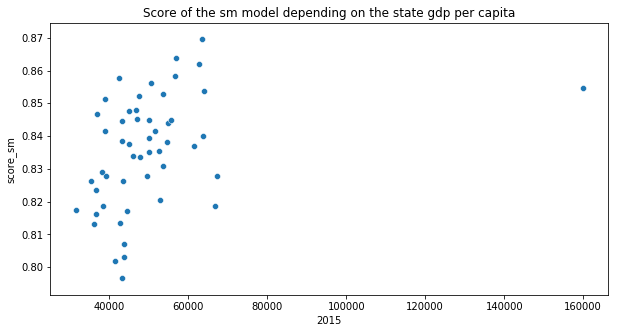

In [35]:
plt.figure(figsize=(10,5))
sns.scatterplot(df_gdp['2015'], df_gdp['score_sm'])
plt.title('Score of the sm model depending on the state gdp per capita')
plt.show()

#### SInon : presque la même map que le gdp par state !! !

https://www.google.com/search?q=states+gdp+us&sxsrf=AOaemvJpoyHJxjMzpleefd3YcF3dHfLZ2A:1635493547903&source=lnms&tbm=isch&sa=X&ved=2ahUKEwjAwNGfkO_zAhXGz4UKHUu9AHAQ_AUoAnoECAEQBA&biw=1536&bih=721&dpr=2.5#imgrc=pCB_AY-BIWx0zM

## DRAFT

In [ ]:
def compute_popularity(name, year, gender):
    #Number of people:
    nb_people = count_year_gender[(count_year_gender['Year']==year) & (count_year_gender['Gender']==gender)]\
    ['Count'].values[0]
    #Number of people with that specific name:
    nb_name = 
    
    return nb_name/nb_people

### Convolutions

In [ ]:
#Source : https://stackoverflow.com/questions/20618804/how-to-smooth-a-curve-in-the-right-way
x = df_final_results['year']
y = df_final_results['score']

def smooth(y, box_pts):
    box = np.ones(box_pts)/box_pts
    y_smooth = np.convolve(y, box, mode='same')
    return y_smooth

plt.figure(figsize=(15,5))
plt.plot(x, y,'o', markersize=2)
plt.plot(x, smooth(y,25), 'r-', lw=2)
#plt.plot(x, smooth(y,20), 'g-', lw=2)
plt.show()